# Linear Schrödinger: Symbolic Computation

# Problem

Study $$(i\partial_t)+\partial_x^2)q(x,t)=0$$ on $(x,t)\in [0,L] \times[0,T)$ with the initial condition $$q(x,0)=q_0(x)$$ and pseudoperiodic boundary conditions $$\partial_x^k q(L,t)=\beta_k q(0,t),~~k=0,1.$$

In order to have an energy conserving system we must choose boundary conditions such that $\beta_0\beta_1=1.$  In what follows we let $\beta_0=1/\beta_1$ and $\beta:=\beta_1$ for simplicity.  Hence, our boundary conditions are

$q(L,t)=\frac{1}{\beta} q(0,t),$

$q_x(L,t)=\beta q(L,t).$

## The UTM

We have the local relation $$(e^{-ikx +\omega t}q)_t-(e^{-ikx+\omega t}(iq_x-kq))_x=0$$ with $\omega(k)=ik^2.$

Integrating around the $(x,t)$ domain of dependence we have the global relation
$$0=\hat{q}_0(k)+e^{\omega T}\hat{q}(k,T)+e^{-ikL}(h_1(\omega,T)-kh_0(\omega,T))-(g_1(\omega,T)-kg_0(\omega,T)),$$ where

$g_j(\omega,t)=\int_0^t e^{\omega s}\partial_x^j u(0,s)ds,$

$h_j(\omega,t)=\int_0^t e^{\omega s}\partial_x^j u(L,s)ds,$

$\hat{q}(k,t)=\int_0^L e^{-ikx}q(x,t)dx,$

Using the boundary conditions, global relation, and the evaluation of the global relation at $-k$ we have a $4\times4$ linear system:

$$\mathcal{A}X=Y$$

where
$$\mathcal{A}=\left(\begin{array}{cccc} e^{-ikL} &-k e^{-ikL}&-1&k\\e^{ikL} &k e^{ikL}&-1&-k\\1&0&-\beta&0\\0&1&0&-1/\beta\end{array}\right),$$
$$X=\left(h_1(\omega,t),h_0(\omega,t),g_1(\omega,t), g_0(\omega,t)\right)^\top,$$
$$Y=\left(-\hat{q}_0(k), -\hat{q}_0(-k),0,0\right)^\top,$$

In [6]:
# dependencies
using PyPlot
using SymPy
using ProgressMeter
#using ApproxFun

k = symbols("k", complex=true, nonzero=true); #we must always avoid the origin...this might not be ok
L = symbols("L", positive=true, real=true);
beta = symbols("beta", nonzero=true, real=true);
q0hat_pos=symbols("q0hat_pos");
q0hat_neg=symbols("q0hat_neg");
x=symbols("x", positive=true, real=true);
t=symbols("t", positive=true, real=true);
A=[exp(-im*k*L) -k*exp(-im*k*L) -1 k; exp(im*k*L) k*exp(im*k*L) -1 -k; 1 0 -beta 0; 0 1 0 -1/beta];
Y=[-q0hat_pos; -q0hat_neg; 0; 0];
gh=\(A,Y);
h1=simplify(gh[1]);
h0=simplify(gh[2]);
g1=simplify(gh[3]);
g0=simplify(gh[4]);

Delta=simplify(-beta/k*det(A))  #scaling by -beta/k to match paper
zetam=simplify(-(h1-k*h0)*Delta)
zetap=simplify(-(g1-k*g0)*Delta)

#check..should equal 0
simplify(zetap-exp(-im*k*L)*zetam+q0hat_pos*Delta)

0

In [7]:
kzero=simplify(factor(solveset(Delta,k)));

mint=-1/(2*PI*Delta)*exp(im*k*(x-L)-im*k^2*t)*zetam;
pint=-1/(2*PI*Delta)*exp(im*k*x-im*k^2*t)*zetap;

# parameters of problem
L = 2*PI;
beta = 1+sqrt(SymPy.Sym(2));
#beta = 1+sqrt(x)|>subs(x,2); #This is a strange way to write beta but it keeps it as a symbol
rts_btwn=100; #find roots between -rts_btwn and rts_btwn
tol=10e-13; #Find roots to this tolerance

#initial condition
#step function
q0(x)=Heaviside(x-L/2);
q0hat(k)=SymPy.integrate(q0(x)*exp(-im*k*x),x,0,L)

free_symbols(mint)

intm=lambdify(mint(t,x,q0hat(k),k,beta,q0hat(-k),L),[k,t,x]) #argument order determined by free_symbols
intp=lambdify(pint(t,x,q0hat(k),k,beta,q0hat(-k),L),[k,t,x]) #argument order determined by free_symbols

krts=simplify(kzero(L,beta))

{n - 1/8 | n in Integers()} U {n + 1/8 | n in Integers()}

We see that all the roots of $\Delta$ are on the real line

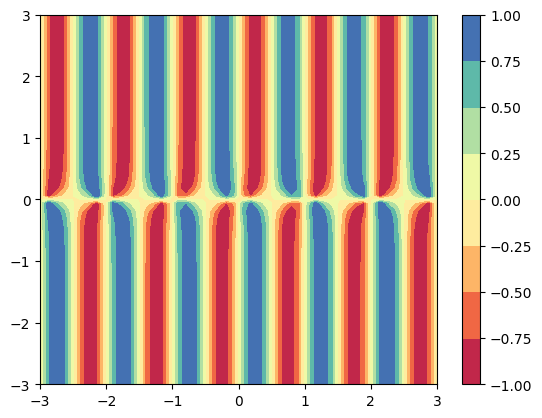

PyPlot.Figure(PyObject <matplotlib.figure.Figure object at 0x32ce0f2d0>)

In [8]:
# plot showing zeros of Delta
D=lambdify(simplify(Delta(beta,L,k)),[k]);
kR = linspace(-3,3,50); kI = linspace(-3,3,50);
zarg = [sin(angle(D(xx+im*yy))) for yy in kI, xx in kR]
DZ=contourf(kR, kI, zarg, cmap=get_cmap("Spectral"))
cbar = colorbar(DZ)
figure()

As shown above, all the zeros of $\Delta$ are on the real line.

In [4]:
using Roots
rd(w)=real(N(D(w)));
@time nkrts=Roots.fzeros(rd, -rts_btwn,rts_btwn); #gives me the roots between -rts_btwn and rts_btwn

tol=10e-13; #Find roots to this tolerance

#make sure we're actually getting roots
@time norms=map(norm,map(D,nkrts))
nrts=nkrts[norms.<tol]
bdrts=nkrts[norms.>tol]

mypolecount=length(nrts);
nofound=length(nkrts);
badno=length(bdrts);

println("Had to throw away $badno (of $nofound) roots!")

  6.498490 seconds (10.38 M allocations: 413.047 MB, 4.44% gc time)
 

 0.137843 seconds (59.94 k allocations: 2.689 MB)
Had to throw away 14 (of 400) roots!


In [36]:
#make sure we're actually getting roots (round 2)...using a slower but more accurate way to check if nkrt is a root
@time norms2=map(norm,N(map(Delta(beta,L,k),bdrts)));
nrts=append!(bdrts[norms2.<tol],nrts)
BADrts=bdrts[norms2.>tol];

mypolecount=length(nrts);
back=length(bdrts)-length(BADrts);

println("Added back $back roots!")

  8.384838 seconds (396.41 k allocations: 16.110 MB, 0.09% gc time)
Added back 42 roots!


Note that this would not work if the roots weren't real

This is strange because the elements of nkrts are all really roots to within $10^{-14}$ but when they are plugged in we are off by more digits.  Where are we losing accuracy??

In [ ]:
BADrts

D(BADrts[1])

N(Delta(beta,L,BADrts[1]))

#These should both be 0!! Where am I losing accuray?

D(-195.875) #Julian object evaluated at 199.875

BADrts[1]

N(Delta(beta,L,-195.87499999999997)) #SymPy object evalated at 199.875 then N takes to Julian